In [46]:
import os
import pandas as pd
import librosa
from librosa import display
import numpy as np
import IPython.display as ipd
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline 

labels = pd.read_csv(
    "train.csv",
    names=['ID', 'Class']
)

# Important!  I've only included a few wav files for demonstration purpose.  

To get the complete dataset, which is the only proper way to train this model, Google "UrbanSound" dataset and follow links.  I just tried and the original dataset was removed from Kaggle. If you locate it, extract all wav files to the /data/Train/*wav directory.  Or better yet, fill up your directory with your own labeled wav files sourced from anywhere. 

If you source your own, you'll need to generate a replacement train.csv file.

In [47]:
classes = labels[1:].Class.unique()
class_nums = pd.factorize(classes)
cdict = { k:v for (k,v) in zip(class_nums[1], class_nums[0])}
inverted_cdict = dict([[v,k] for k,v in cdict.items()])
train_files = glob('{}/data/Train/*.wav'.format(os.path.abspath('.')))
cdict

{'jackhammer': 0,
 'siren': 1,
 'drilling': 2,
 'engine_idling': 3,
 'street_music': 4,
 'air_conditioner': 5,
 'dog_bark': 6}

In [48]:
TARGET_LEN = 88200
HZ_SLICE = 14

def data_to_spec(data):
    D = librosa.stft(data)
    return librosa.power_to_db(np.abs(D)**2, ref=np.median)

def data_to_mfcc(data):
    return librosa.feature.mfcc(data) 

def file_to_spec(filename):
    data, rate = librosa.load(filename)
    if data.shape[0] != TARGET_LEN: # handle short sounds
        data = extend_short_sounds(data)
    return data_to_spec(data)

def file_to_mfcc(filename):
    data, rate = librosa.load(filename)
    if data.shape[0] != TARGET_LEN: # handle short sounds
        data = extend_short_sounds(data)
    return data_to_mfcc(data)

def file_to_label(filename):
    fname = os.path.basename(filename)
    cid = fname.replace('.wav', '')
    classname = labels.loc[labels['ID'] == cid]
    return classname.values.tolist()[0][1] 

def show_file(filename):
    plt.title(file_to_label(filename))
    librosa.display.specshow(file_to_spec(filename), x_axis='time', y_axis='linear');
    plt.colorbar(); 
    
def extend_short_sounds(data):
    stretched = librosa.effects.time_stretch(data, rate=data.shape[0]/TARGET_LEN)
    return stretched[:TARGET_LEN:]

def drop_frequency_bands(data):
    return data[::HZ_SLICE,]

def show_progress(progress):
    if progress % 40:
        print('.', end="")
    else:
        print('.')

In [49]:
f = train_files[0]
ss = file_to_spec(f)
mm = file_to_mfcc(f)
print(ss.shape)
mm.shape

(1025, 173)


(20, 173)

In [50]:
def wav_to_stft(files, labels):
    info = []
    data_arr = []
    progress = 0
    for filename in files:
        try:
            d = file_to_mfcc(filename)
            #d = drop_frequency_bands(d)
            data_arr.append(d)
            if isinstance(labels, pd.DataFrame): 
                # labeled case
                info.append( file_to_label(filename) )
            else:                                
                # unlabled case
                info.append(filename)
            progress+=1
            show_progress(progress)
            #print(d.shape)
        except:
            # As mentioned above, this notebook does not include the wav files
            # so if running with incomplete data, just skip via exception.
            pass 
    return data_arr, info

# uncomment to calculate and save

train_data, train_labels = wav_to_stft(train_files, labels)
np.save('train_spec_mfcc', train_data)
np.save('train_label_mfcc', train_labels)
print('done')

....................done


In [51]:
# Load the saved results (comment in and out as needed)
train_spec_load = np.load('./train_spec_mfcc.npy')
train_labels_load = np.load('./train_label_mfcc.npy')
train_spec_load.shape

def mean_mfcc_features(x):
    return x.mean(axis=2)

t = train_spec_load


train_spec = mean_mfcc_features(t)
train_spec.shape


(20, 20)

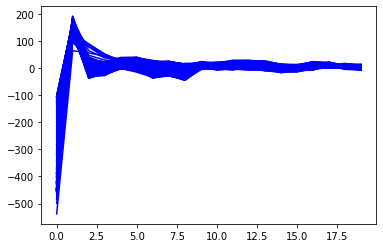

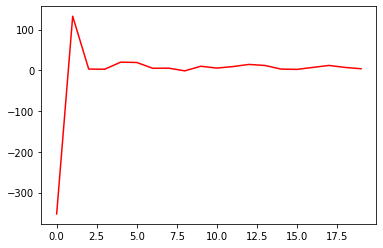

In [52]:

plt.plot(t[0], 'b')
plt.figure()
plt.plot(train_spec[0], 'r')

In [54]:
ipd.Audio('data/Train/2140.wav')